# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
argopy.set_options(mode='expert')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

In [2]:
def get_dataow(file_path):
    
    # load from .met file
    mat_dict_load = sp.io.loadmat(file_path)
    
    #create a xarray dataset
    ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

    return ds_ref

__Input__

In [3]:
float_WMO = 4901218
prof_num = 47

## 1. Load float profile

using argopy

In [4]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [5]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 66, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 5 ... 60 61 62 63 64 65
    TIME                      (N_PROF) datetime64[ns] 2012-03-18T09:48:09.001...
    LATITUDE                  (N_PROF) float64 42.42
    LONGITUDE                 (N_PROF) float64 -47.72
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 1
    CYCLE_NUMBER              (N_PROF) int64 47
    DATA_CENTRE               (N_PROF) <U2 'AO'
    DATA_MODE                 (N_PROF) <U1 'D'
    DATA_STATE_INDICATOR      (N_PROF) <U4 '2C  '
    DC_REFERENCE              (N_PROF) <U32 '3444_44265_047                  '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 '2.02                            '
    FLOAT_SERIAL_NO           (N_PROF) <U32 '1029                            '
    PI_NAME                   (N_PROF) <U64 'BRECK OWENS                     ...
    PLATFORM_NUMBER           (N_PROF) int64 4901218
    PLATFORM_TYPE             (N_PROF) <U32 'SOLO_W                          '
    POSITIONING_SYSTEM        (N_PROF) <U8 'ARGOS   '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 5.0 10.0 ... 1200.0
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 5.0 10.0 ... 1200.0
    PRES_ADJUSTED_ERROR       (N_PROF) float32 2.4
    PRES_ADJUSTED_QC          (N_PROF) int64 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF) <U1 'B'
    PROFILE_TEMP_QC           (N_PROF) <U1 'B'
    PROJECT_NAME              (N_PROF) <U64 'US ARGO PROJECT                 ...
    PSAL                      (N_PROF, N_LEVELS) float32 34.875 ... 34.871
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 34.874863 ... 34.870995
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.010000943 ... 0.01...
    PSAL_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    PSAL_QC                   (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TEMP                      (N_PROF, N_LEVELS) float32 16.021 16.028 ... 4.13
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 16.021 16.028 ... 4.13
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TEMP_QC                   (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2012-03-18T09:50:08.001...
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 'Primary sampling: averaged [dat...
    WMO_INST_TYPE             (N_PROF) int64 851
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/11/03
    Fetched_constraints:  phy;WMO4901218_CYC47
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/aoml/4901...
    history:              Transformed with point2profile

In [6]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [7]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 66, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 5 ... 60 61 62 63 64 65
    TIME                      (N_PROF) datetime64[ns] 2012-03-18T09:48:09.001...
    LATITUDE                  (N_PROF) float64 42.42
    LONGITUDE                 (N_PROF) float64 -47.72
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 1
    CYCLE_NUMBER              (N_PROF) int64 47
    DATA_CENTRE               (N_PROF) <U2 'AO'
    DATA_MODE                 (N_PROF) <U1 'D'
    DATA_STATE_INDICATOR      (N_PROF) <U4 '2C  '
    DC_REFERENCE              (N_PROF) <U32 '3444_44265_047                  '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 '2.02                            '
    FLOAT_SERIAL_NO           (N_PROF) <U32 '1029                            '
    PI_NAME                   (N_PROF) <U64 'BRECK OWENS                     ...
    PLATFORM_NUMBER           (N_PROF) int64 4901218
    PLATFORM_TYPE             (N_PROF) <U32 'SOLO_W                          '
    POSITIONING_SYSTEM        (N_PROF) <U8 'ARGOS   '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 5.0 10.0 ... 1200.0
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 5.0 10.0 ... 1200.0
    PRES_ADJUSTED_ERROR       (N_PROF) float32 2.4
    PRES_ADJUSTED_QC          (N_PROF) int64 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF) <U1 'B'
    PROFILE_TEMP_QC           (N_PROF) <U1 'B'
    PROJECT_NAME              (N_PROF) <U64 'US ARGO PROJECT                 ...
    PSAL                      (N_PROF, N_LEVELS) float32 34.875 ... 34.871
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 34.874863 ... 34.870995
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.010000943 ... 0.01...
    PSAL_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    PSAL_QC                   (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TEMP                      (N_PROF, N_LEVELS) float32 16.021 16.028 ... 4.13
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 16.021 16.028 ... 4.13
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TEMP_QC                   (N_PROF, N_LEVELS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2012-03-18T09:50:08.001...
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 'Primary sampling: averaged [dat...
    WMO_INST_TYPE             (N_PROF) int64 851
    ptmp                      (N_PROF, N_LEVELS) float32 16.020214 ... 4.0354953
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/11/03
    Fetched_constraints:  phy;WMO4901218_CYC47
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/aoml/4901...
    history:              Transformed with point2profile

In [8]:
ds_f.PRES.max().values

array(1200.)

## 2. Load reference data

__data without class selection__

In [10]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_noclass.mat'
ds_ref = get_dataow(file_path)
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 655, n_profiles: 250)
Coordinates:
    long     (n_profiles) float64 310.2 310.5 310.7 312.0 ... 309.8 309.9 304.7
    lat      (n_profiles) float64 42.04 41.23 40.8 42.77 ... 41.29 41.64 43.56
    dates    (n_profiles) datetime64[ns] 2014-01-01 2014-01-01 ... 2016-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 2.081 15.94 17.74 ... nan nan nan
    sal      (n_pres, n_profiles) float64 33.07 36.13 36.45 ... nan nan nan

__data with class selection k=5__

In [ ]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_k6_CTD.mat'
ds_ref_class_k5 = get_dataow(file_path)
ds_ref_class_k5

__data with class selection k=6__

In [ ]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_k6.mat'
ds_ref_class_k6 = get_dataow(file_path)
ds_ref_class_k6

## 3. Plots

__Potential temperature__

NameError: name 'ds_ref_class_k5' is not defined

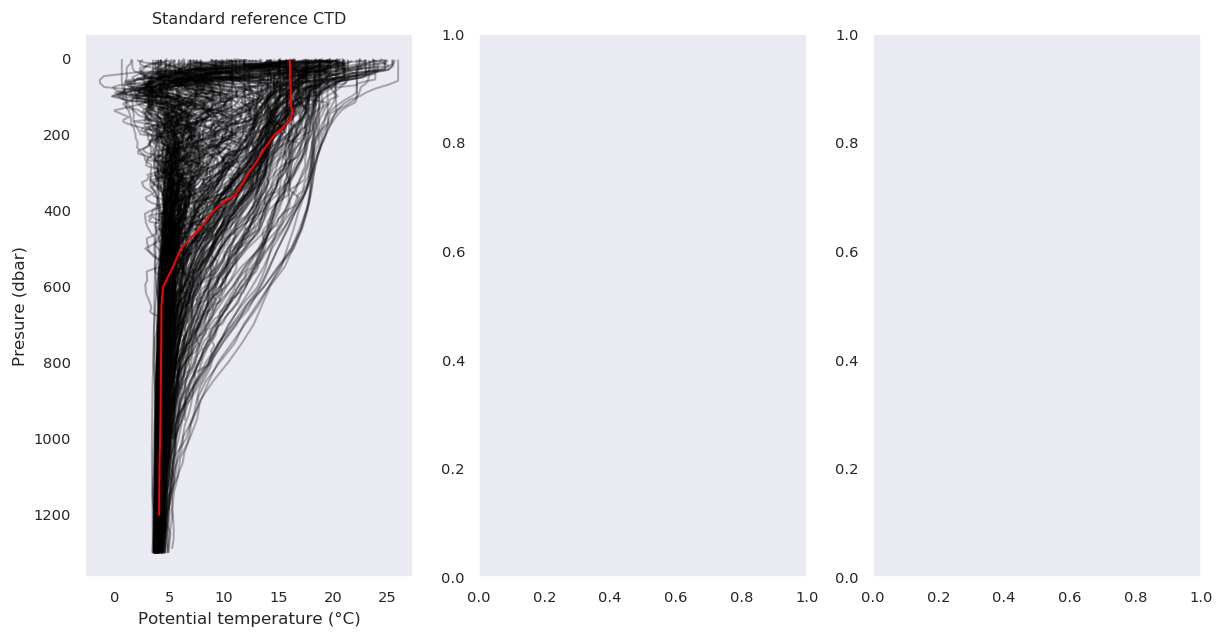

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['ptmp'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference CTD')
#ax[0].legend()

for i in range(len(ds_ref_class_k5['n_profiles'])):
    ax[1].plot(ds_ref_class_k5['ptmp'].isel(n_profiles = i), ds_ref_class_k5['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference CTD')
#ax[1].legend()

#for i in range(len(ds_ref_class_k6['n_profiles'])):
#    ax[2].plot(ds_ref_class_k6['ptmp'].isel(n_profiles = i), ds_ref_class_k6['pres'].isel(n_profiles = i), 'k', alpha=0.3);
#ax[2].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
#ax[2].invert_yaxis()
#ax[2].set_ylabel('Presure (dbar)', fontsize=10);
#ax[2].set_xlabel('Potential temperature (°C)', fontsize=10);
#ax[2].set_title('PCM-based reference k=6')

__Salinity__

NameError: name 'ds_ref_class_k5' is not defined

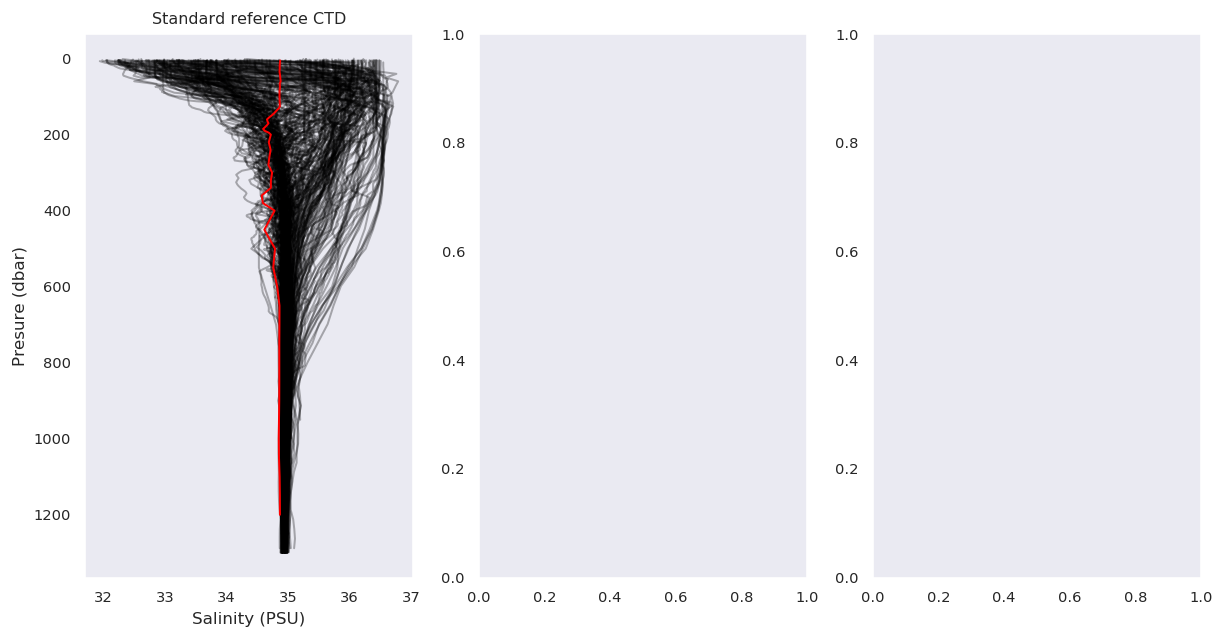

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['sal'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference CTD')
#ax[0].legend()

for i in range(len(ds_ref_class_k5['n_profiles'])):
    ax[1].plot(ds_ref_class_k5['sal'].isel(n_profiles = i), ds_ref_class_k5['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference CTD')
#ax[1].legend()

for i in range(len(ds_ref_class_k6['n_profiles'])):
    ax[2].plot(ds_ref_class_k6['sal'].isel(n_profiles = i), ds_ref_class_k6['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[2].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[2].invert_yaxis()
ax[2].set_ylabel('Presure (dbar)', fontsize=10);
ax[2].set_xlabel('Salinity (PSU)', fontsize=10);
ax[2].set_title('PCM-based reference k=6')

Plot ellipses with and without class selection

NameError: name 'ds_ref_class_k5' is not defined

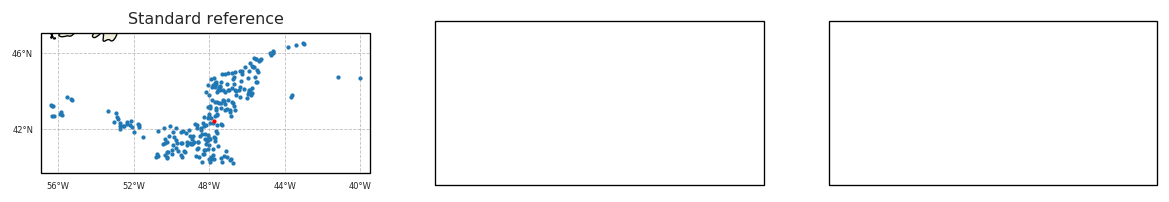

In [13]:
#selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

# without class selection
p1 = ax[0].scatter(ds_ref['long'], ds_ref['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[0].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[0].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[0].gridlines(crs=ax[0].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].set_title('Standard reference')
long_180 = np.mod(ds_ref['long']+180,360)-180
ax[0].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
ax[0].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])

# with class selection k=5
p1 = ax[1].scatter(ds_ref_class_k5['long'], ds_ref_class_k5['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[1].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[1].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[1].gridlines(crs=ax[1].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[1].set_title('PCM-based reference')
ax[1].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
ax[1].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])

# with class selection k=6
p1 = ax[2].scatter(ds_ref_class_k6['long'], ds_ref_class_k6['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[2].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[2].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[2].gridlines(crs=ax[2].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[2].set_title('PCM-based reference k=6')
ax[2].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
ax[2].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])

ax[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plot number of reference profiles per profile

In [ ]:
# load standard reference data
file_path1 = 'mat_files/3901915_n_ref_prof_noclass.mat'
mat_dict = sp.io.loadmat(file_path1)
# load standard PCM based data k=6
file_path2 = 'mat_files/3901915_n_ref_prof_class_k6.mat'
mat_dict_class_k6 = sp.io.loadmat(file_path2)
# load standard PCM based data k=5
file_path3 = 'mat_files/3901915_n_ref_prof_class_k5.mat'
mat_dict_class_k5 = sp.io.loadmat(file_path3)

In [ ]:
labels = np.arange(0,len(mat_dict['n_ref_prof'][0])+1,10)

x = np.arange(1,len(mat_dict['n_ref_prof'][0])+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.plot(x, mat_dict['n_ref_prof'][0], 'o-', label='Standard reference')
rects2 = ax.plot(x, mat_dict_class_k5['n_ref_prof'][0], 'o-', label='PCM-based reference k=5')
rects2 = ax.plot(x, mat_dict_class_k6['n_ref_prof'][0], 'o-', label='PCM-based reference k=6')

ax.set_ylabel('# of reference profiles', fontsize=10)
ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=10)
ax.set_title('Reference profiles per float profile')
ax.set_xticks(labels)
ax.set_xlim([0.5,len(mat_dict['n_ref_prof'][0])+0.5])
#ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')